In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

2023-06-06 21:04:56.589152: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 21:04:56.592442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-06 21:04:56.629862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-06 21:04:56.631034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 21:04:57.443133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, size_ens): 

    weights_ann_1 = ann_15.get_weights()
    weights_ann_2 = ann_20.get_weights()
    
    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1



    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles_1[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)


    # hidden_layer_bias_2 = np.expand_dims(hidden_layer_bias_2, 0)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2
#     hidden_layer_bias_2 = hidden_layer_bias_2 + hidden_layer_bias_2


    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, target_dim)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + target_dim)].reshape(size_ens, 1, target_dim)

    # output_layer_bias_2 = np.expand_dims(output_layer_bias_2, 0)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]

#     print(weights_1.shape)
    
    # print(weights_2.shape)

    avg_weights = initial_ensembles[:, -1].reshape(-1,1)
    
    # avg_weights_not_sig = avg_weights.reshape(avg_weights.shape[0], 1, avg_weights.shape[1])
    
    
    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])
    

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    return final_output_1 + final_output_2

In [3]:
def ann(hidden = 32, input_shape = 256, output_shape = 2): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [4]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [5]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_both.npy")

In [6]:
# y_valid

In [7]:
y_valid = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")

In [8]:
# y_valid

In [9]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# y_valid

In [11]:
y_train = y_valid.values[:,1:]

In [12]:
y_train = std_targets.transform(y_train)

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(alogp_bottleneck, y_train, test_size = 0.25, shuffle = True, 
                                                     random_state = 42)

In [15]:
smiles_feats_train = x_train[:, :32]

In [16]:
rdkit_feats_train = x_train[:, 32:]

In [17]:
smiles_feats_valid = x_valid[:, :32]
rdkit_feats_valid = x_valid[:, 32:]

In [18]:
h1, h2 = 16, 16

In [19]:
ann_15 = ann(h1, 32, 2)

2023-06-06 21:04:58.668575: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
ann_20 = ann(h2, 32, 2)

In [21]:
total_weights_1 = ann_15.count_params()

In [22]:
total_weights_2 = ann_20.count_params()

In [23]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [24]:
total_weights

1125

In [25]:
# generate MVN from 0 and some var
initial_ensembles_mean = np.zeros((total_weights,))

In [26]:
lambda1 = 1

In [27]:
initial_ensembles_cov = lambda1*np.identity(total_weights)

In [28]:
reduction = 4

In [29]:
size_ens = total_weights//reduction

In [30]:
initial_ensembles = mvn(initial_ensembles_mean, initial_ensembles_cov).rvs(size_ens)

In [31]:
initial_ensembles.shape

(281, 1125)

In [32]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles):
    mu_bar = initial_ensembles.mean(0)
    G_u = get_targets_with_weights(data1, data2, initial_ensembles, size_ens = size_ens)
    G_u = G_u.reshape(G_u.shape[0], G_u.shape[1]*G_u.shape[2])
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [33]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [34]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [35]:
def get_updated_ensemble(data1, data2, initial_ensembles):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    mid_quant = C@np.linalg.inv(D + lambda_inv)
    right_quant = y_train.ravel().reshape(-1,1) - G_u.T
    mid_times_right = mid_quant@right_quant
    updated_ensemble = (initial_ensembles.T + mid_times_right)
    return updated_ensemble.T

In [36]:
target_dim = 2

In [37]:
lambda_D = 1

In [38]:
u_bar, G_bar, G_u = calculate_mu_bar_G_bar(smiles_feats_train, rdkit_feats_train, initial_ensembles)

In [39]:
G_bar.shape

(1438, 1)

In [40]:
lambda_inv = np.linalg.inv(lambda_D*np.identity(G_bar.shape[0]))

In [41]:
G_u.shape

(281, 1438)

In [42]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [43]:
from joblib import Parallel, delayed

In [44]:
# catch = Parallel(n_jobs = 15, verbose = 3)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))

In [45]:
for i in range(0,10000):
    
    initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    
    G_u_train = get_targets_with_weights(smiles_feats_train, rdkit_feats_train, initial_ensembles, size_ens = size_ens)
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
    G_u_train = np.array(catch)
    
    y_train_cur = std_targets.inverse_transform(y_train)
    
    li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_train = ui_train - li_train
    avg_width_train = width_train.mean(0)
    
    ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
    coverage_train= ind_train.mean(0)
    
    averaged_targets_train = G_u_train.mean(0)
    rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))
    print(rmse_train, coverage_train, avg_width_train)
    
    G_u_test = get_targets_with_weights(smiles_feats_valid, rdkit_feats_valid, initial_ensembles, size_ens = size_ens)
    
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))
    G_u_test = np.array(catch)
    
    y_valid_cur = std_targets.inverse_transform(y_valid)    
    
    li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_test = ui_test - li_test
    avg_width_test = width_test.mean(0)
    
    ind_test = (y_valid_cur >= li_test) & (y_valid_cur <= ui_test)
    coverage_test= ind_test.mean(0)
    
    averaged_targets_test = G_u_test.mean(0)
    rmse_test = np.sqrt(((y_valid_cur -averaged_targets_test)**2).mean(0))    
    
    # plt.scatter(y_valid[:, 0], averaged_targets_test[:,0])
    # plt.axline((0,0), slope = 1, c= "black")
    # plt.show()
    # plt.scatter(y_valid[:,1], averaged_targets_test[:, 1])
    # plt.axline((0,0), slope = 1, c= "black")
    # plt.show()
    
    if coverage_train.mean() < 0.95:
        break
    
    print(rmse_test, coverage_test, avg_width_test)

[ 3.1051163  60.55913727] [1. 1.] [ 116.41131147 2506.44896486]
[ 3.05732003 60.16792826] [1. 1.] [ 115.18755116 2459.90755072]
[ 2.17844875 41.25827476] [1. 1.] [  89.48664151 1914.20445548]
[ 2.09346684 40.9691746 ] [1. 1.] [  88.25040322 1883.21061607]
[ 2.18854485 33.10747459] [1. 1.] [  73.5818114  1638.00256515]
[ 2.19458501 32.66348853] [1. 1.] [  73.17758895 1612.2026226 ]
[ 2.37708947 31.98608451] [1. 1.] [  66.03378062 1407.83363829]
[ 2.32305381 31.31714652] [1. 1.] [  65.97360198 1394.68244761]
[ 2.01013523 29.0044091 ] [1. 1.] [  56.50728869 1263.01797673]
[ 1.95125138 28.62905248] [1. 1.] [  56.23956604 1245.5331262 ]
[ 2.01794431 27.44507713] [1. 1.] [  49.73717965 1110.46426092]
[ 1.92739271 24.73209984] [1. 1.] [  49.86517999 1098.81649768]
[ 1.53384723 31.65865822] [1. 1.] [  45.16130227 1062.9889988 ]
[ 1.42739478 28.56658545] [1. 1.] [  45.35660967 1044.63379524]
[ 1.42182681 32.66779213] [1. 1.] [ 39.89619891 933.64313401]
[ 1.33341756 29.79283512] [1. 1.] [ 39.824

KeyboardInterrupt: 

In [46]:
G_u_test.shape

(281, 240, 2)

In [47]:
import random

In [48]:
random_idx = random.sample(range(y_valid_cur.shape[0]), k = 8)

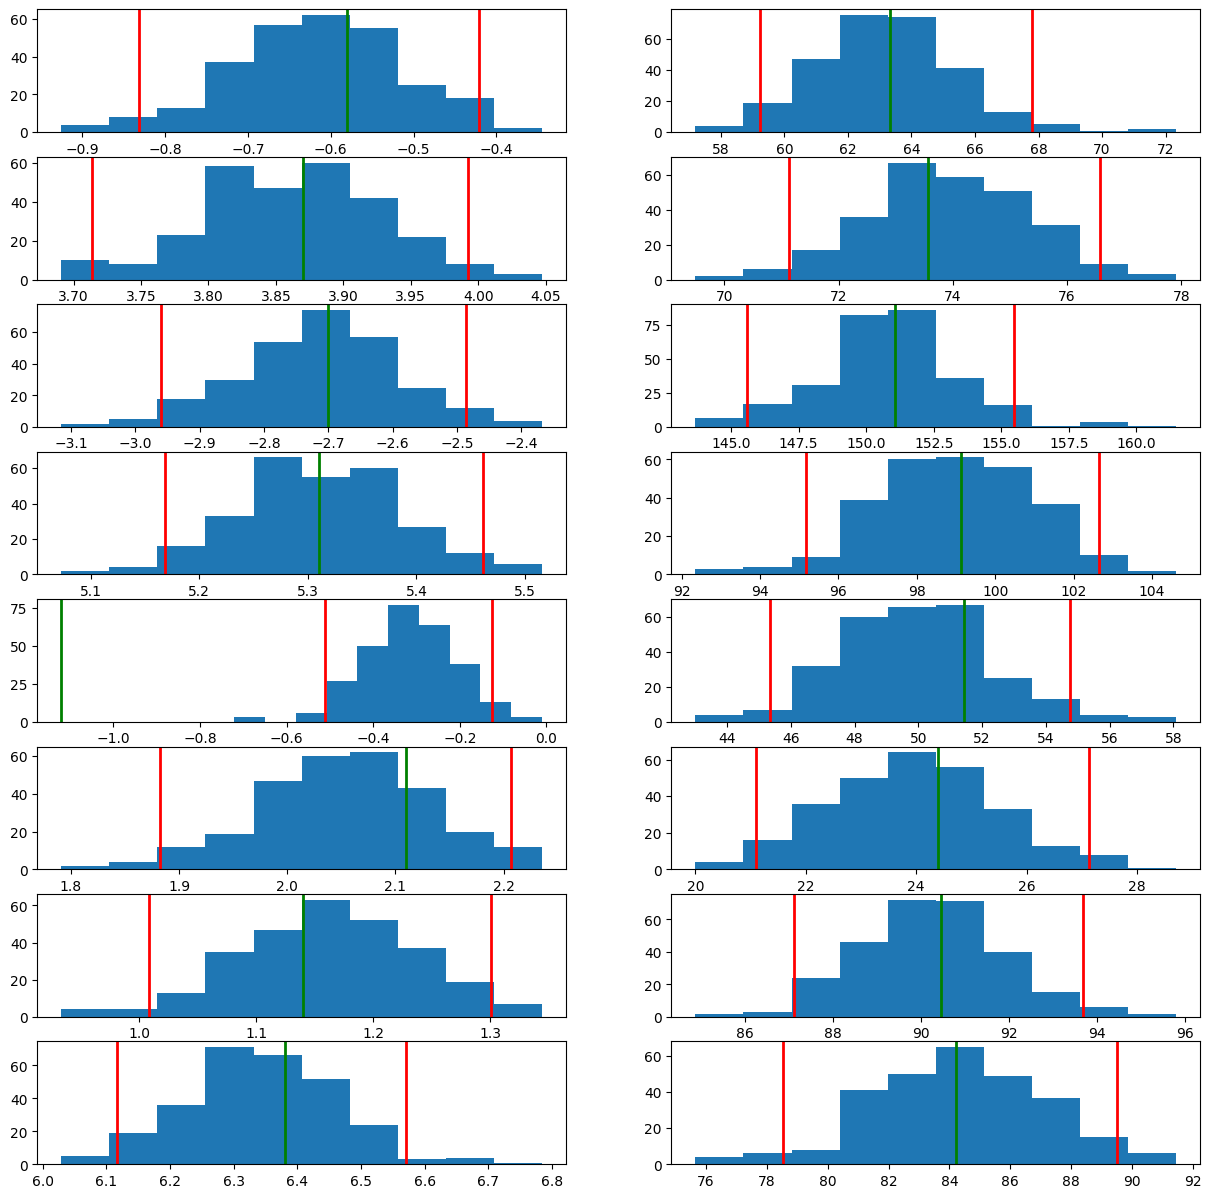

In [50]:
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
# axs = axs.ravel()
# counter = 0
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_valid_cur[i,:]
    preds = G_u_test[:, i,:]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0,:]
    uis = percts[1,:]
    
    
    axs[idx, 0].hist(preds[:,0])
    axs[idx, 0].axvline(truth[0], color='green', linewidth=2)
    axs[idx, 0].axvline(lis[0], color='red', linewidth=2)
    axs[idx, 0].axvline(uis[0], color='red', linewidth=2)
    
    axs[idx, 1].hist(preds[:,1])
    axs[idx, 1].axvline(truth[1], color='green', linewidth=2)
    axs[idx, 1].axvline(lis[1], color='red', linewidth=2)
    axs[idx, 1].axvline(uis[1], color='red', linewidth=2)
    
    # counter+=2
    # print(counter)
    
    # plt.show()
plt.savefig('prediction_intervals.png', bbox_inches='tight')

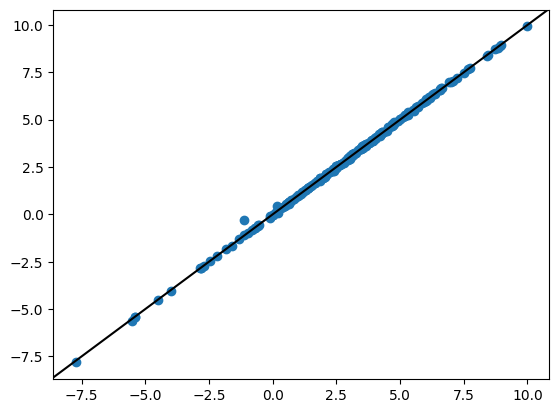

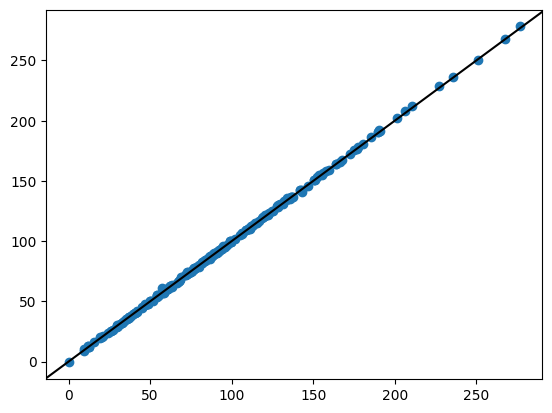

In [51]:
plt.scatter(y_valid_cur[:, 0], averaged_targets_test[:,0])
plt.axline((0,0), slope = 1, c= "black")
plt.show()
plt.scatter(y_valid_cur[:,1], averaged_targets_test[:, 1])
plt.axline((0,0), slope = 1, c= "black")
plt.show()